In [1]:
# !pip install pretrainedmodels

In [22]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models#, transforms

from torchvision import transforms as T


import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models



%matplotlib inline

PyTorch Version:  1.3.0
Torchvision Version:  0.4.1


In [23]:
data_path = "./data/train/train"
test_path = "./data/test/test"
extraimage_path = "./data/extraimages/extraimages"

In [24]:
print('Train set:')
class_distrbution = {}
for cls in os.listdir(data_path):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join(data_path, cls)))))
    class_distrbution[cls] =  len(os.listdir(os.path.join(data_path, cls)))
im = Image.open(data_path+'/cgm/train-cgm-738.jpg')
print(im.size)
class_distrbution

Train set:
cgm:773
cmd:2658
healthy:316
cbb:466
cbsd:1443
(500, 500)


{'cgm': 773, 'cmd': 2658, 'healthy': 316, 'cbb': 466, 'cbsd': 1443}

In [25]:
# # Transformations for both the training and testing data
# mean=[0.4543, 0.5137, 0.3240]
# std=[0.1949, 0.1977, 0.1661]


# train_transforms = transforms.Compose([transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224), #448, 299, 224, 331
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean,std=std)])

# test_transforms = transforms.Compose([ transforms.Resize(224),
#                                        transforms.CenterCrop(224),
#                                        transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean,std=std)])

# # normalize = transforms.Normalize(mean=mean, std=std)

In [26]:
# A function to perform color distortion in images
# It is used in SimCLR alongwith random resized cropping
# Here, s is the strength of color distortion.

def get_color_distortion(s = 1.0):
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
    
    # p is the probability of grayscale, here 0.2
    rnd_gray = T.RandomGrayscale(p=0.2)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    
    return color_distort

In [46]:


# class CassavaDataset(Dataset):
#     def __init__(self, path, transform=None):
#         self.classes = os.listdir(path)
#         self.path = [f"{path}/{className}" for className in self.classes]
#         self.file_list = [glob.glob(f"{x}/*") for x in self.path]
#         self.transform = transform

#         files = []
#         class_names = {}
#         for i, className in enumerate(self.classes):
#             for fileName in self.file_list[i]:
#                 files.append([i, className, fileName])

#                 name = str(i)+'-'+className
#                 if name not in class_names:
#                     class_names[name] = 1
#                 else:
#                     class_names[name] += 1
#         self.file_list = files
#         print(class_names)
#         files = None

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         fileName = self.file_list[idx][2]
#         classCategory = self.file_list[idx][0]
#         im = Image.open(fileName)
#         if self.transform:
#             im = self.transform(im)
        
# # #         return im.view(3, 448, 448), classCategory
#         return im.view(3, 224, 224), classCategory
# # #         return im.view(3, 299, 299), classCategory
# #         return im.view(3, 331, 331), classCategory   # NASNetLarge 331x331

In [90]:
class CassavaDataset(Dataset):
    def __init__(self, path, mutation = False):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.mutation = mutation

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])

                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
#         print(class_names)
        files = None

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = get_color_distortion(1)(res)
        return res

    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        image = Image.open(fileName)
        
        im = T.Resize((250, 250))(image)
        
#         if self.transform:
#             im = self.transform(im)
        
# #         return im.view(3, 448, 448), classCategory
#         return im.view(3, 224, 224), classCategory
# #         return im.view(3, 299, 299), classCategory
#         return im.view(3, 331, 331), classCategory   # NASNetLarge 331x331

        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            
            sample = {'image1': image1, 'image2': image2, 'label': classCategory}
            
#             return image1, image2, classCategory
        else:
            
            image = T.Resize((224, 224))(image)
            image = self.tensorify(image)
            
            sample = {'image': image, 'label': classCategory}
            
#             return image, classCategory

        return sample

In [91]:
train_data = CassavaDataset(data_path, mutation = False)

test_data = CassavaDataset(test_path, mutation = False)

extraimage_data = CassavaDataset(extraimage_path, mutation = True) #maybe need an other trasforms, I had to change the dataset structure :)

In [92]:
# extraimage_data

In [93]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 0.2
shuffle_dataset = True
random_seed= 42 #42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [94]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size_train = 16 #125
batch_size_eval = 16 #250
n_workers = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train,
                                             sampler = train_sampler, num_workers = n_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_eval,
                                             sampler = valid_sampler, num_workers = n_workers)

unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size = batch_size_eval, 
                                              shuffle = True, num_workers = n_workers) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [95]:
# train_loader

In [96]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [99]:

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

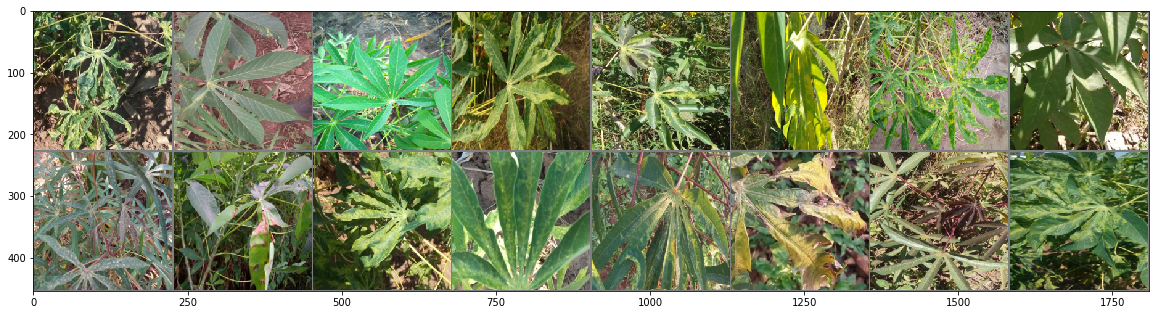

In [117]:
dataiter = iter(train_loader)

output = dataiter.next()

images, labels = output['image'], output['label']

# print(labels)
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

For augmented data

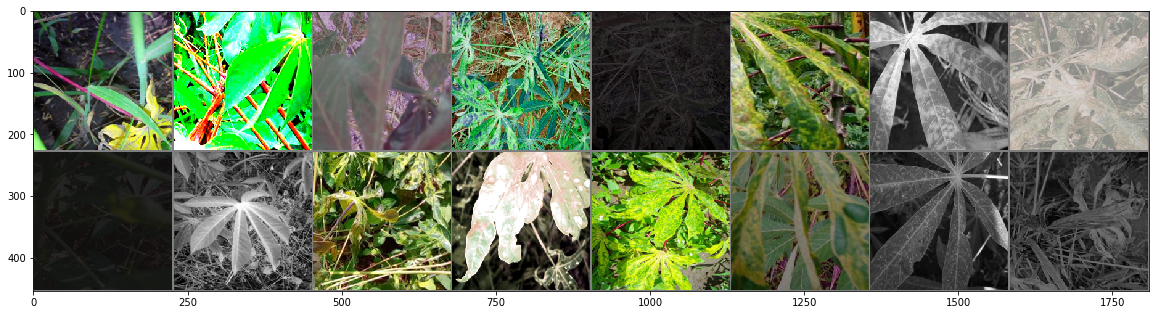

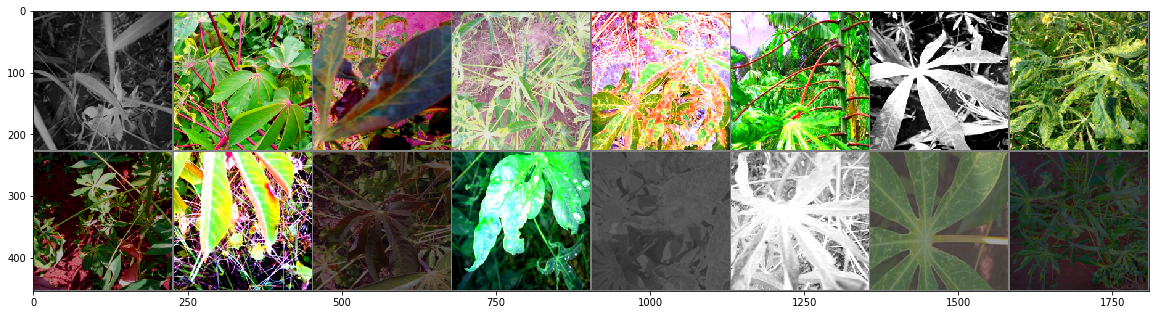

In [118]:
# dataiter = iter(unlabeled_loader)
# images_1, images_2, labels = dataiter.next()

# # print(labels)
# img_grid_1 = torchvision.utils.make_grid(images_1)
# img_grid_2 = torchvision.utils.make_grid(images_2)

# # Image 1
# matplotlib_imshow(img_grid_1, one_channel=False)
# # Image 2
# matplotlib_imshow(img_grid_2, one_channel=False)


dataiter = iter(unlabeled_loader)

output = dataiter.next()

images_1, images_2, labels = output['image1'], output['image2'], output['label']

img_grid_1 = torchvision.utils.make_grid(images_1)
img_grid_2 = torchvision.utils.make_grid(images_2)

# Image 1
matplotlib_imshow(img_grid_1, one_channel=False)
# Image 2
matplotlib_imshow(img_grid_2, one_channel=False)

In [119]:
class Additional(nn.Module):
    def __init__(self, modelA,in_features,nb_classes=5, freeze = False):
        super(Additional, self).__init__()
        self.modelA = modelA
        # Remove last linear layer
#         self.modelA.fc = nn.Identity() # for resnet
        self.modelA.last_linear = nn.Identity() #for re_renext
#         self.modelA.classifier = nn.Identity()    # densenet201
        for p in self.modelA.parameters():
            if freeze:
                p.requires_grad = False
            else :
                p.requires_grad = True
        
        # Create new classifier
        self.fc_1 = nn.Linear(in_features,256)
        self.fc_2 = nn.Linear(256,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #model
        x = self.modelA(x.clone())  
        x = x.view(x.size(0), -1)
        
        #FC
        x  = self.dropout(self.fc_1(F.relu(x)))
        x = self.dropout(self.fc_2(F.relu(x)))
        x = self.fc_out(F.relu(x))
        
        return x

In [120]:
from torchvision.models import resnet18
from collections import OrderedDict
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'resnet18' 
# # resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
# resnet = pretrainedmodels.resnet18(pretrained=False)

# # num_fits = resnet_model.fc.in_features

# defining our deep learning architecture
resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnet.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25)) # why 25 ?
]))

resnet.fc = classifier

In [121]:
# can view the summary if you like
resnet.to(device)
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [122]:
# Code for NT-Xent Loss function, explained in more detail in the article

tau = 0.05 # best is 0.1 (to be checked)

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [123]:
# Defining data structures for storing training info

losses_train = []
num_epochs = 10

# using SGD optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists('results'):
    os.makedirs('results')

# load pretrained model, optimizer and training losses file if model.pth file is available
if(os.path.isfile("results/model.pth")):
    resnet.load_state_dict(torch.load("results/model.pth"))
    optimizer.load_state_dict(torch.load("results/optimizer.pth"))

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = 1e-6
        param_group['lr'] = 0.000003

    temp = np.load("results/lossesfile.npz")
    losses_train = list(temp['arr_0'])

In [124]:
# Boolean variable on whether to perform training or not 
# Note that this training is unsupervised, it uses the NT-Xent Loss function

TRAINING = False

def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
    # get resnet in train mode
    resnet.train()

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []

        # run a for loop for each batch
        for (_, sample_batched) in enumerate(unlabeled_loader):
            
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']

            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = resnet(x1)
            y2 = resnet(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))

        # Plot the training losses Graph and save it
        fig = plt.figure(figsize=(10, 10))
        sns.set_style('darkgrid')
        plt.plot(losses_train)
        plt.legend(['Training Losses'])
        plt.savefig('losses.png')
        plt.close()

        # Store model and optimizer files
        torch.save(resnet.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(losses_train))

In [125]:
# a function used to plot t-SNE visualizations
def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.savefig(fname)
    plt.close()

# Boolean variable to control whether to perform t-SNE visualization or not
TSNEVIS = False

if TSNEVIS:
    # run resnet in eval mode
    resnet.eval()

    # get TSNE visualizations of 10% training dataset
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    # get TSNE visualizations of testing dataset
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

# Removing the last layer and the relu layer, we remove layers incrementally and look t-SNE visualizations
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

# removing one more layer, our entire projection head will be removed afte this
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_train.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_test.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

In [ ]:
# Boolean variable to control whether to train the linear classifier or not
LINEAR = False

class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = torch.nn.Linear(100, 25)

    def forward(self, x):
        x = self.fc1(x)
        return(x)

if LINEAR:

    if not os.path.exists('linear'):
        os.makedirs('linear')

    # getting our linear classifier
    linear_classifier = LinearNet()

    # moving it to device
    linear_classifier.to(device)

    # using SGD as a linear optimizer
    linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

    #number of epochs
    num_epochs_linear = 10

    # Boolean variable to control training of linear classifier
    LINEAR_TRAINING = True

    # Defining data structures to store train and test info for linear classifier
    losses_train_linear = []
    acc_train_linear = []
    losses_test_linear = []
    acc_test_linear = []

    # a variable to keep track of the maximum test accuracy, will be useful to store 
    # model parameters with the best test accuracy
    max_test_acc = 0

    # if a model exists in the linear folder, load it
    if(os.path.isfile("linear/model.pth")):

        # load state dict for linear model and optimizer
        linear_classifier.load_state_dict(torch.load("linear/model.pth"))
        linear_optimizer.load_state_dict(torch.load("linear/optimizer.pth"))

        # change learning rate, you can change its values if you don't feel its necessity while training
        for g in linear_optimizer.param_groups:
          g['lr'] = 0.001
          g['weight_decay'] = 0

        # load data structures
        temp = np.load("linear/linear_losses_train_file.npz")
        losses_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_losses_test_file.npz")
        losses_test_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_train_file.npz")
        acc_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_test_file.npz")
        acc_test_linear = list(temp['arr_0'])

    # Run a for loop for training the linear classifier
    for epoch in range(num_epochs_linear):

        if LINEAR_TRAINING:

            # run linear classifier in train mode
            linear_classifier.train()

            # a list to store losses for each batch in an epoch
            epoch_losses_train_linear = []
            epoch_acc_train_num_linear = 0.0
            epoch_acc_train_den_linear = 0.0

            # for loop for running through each batch
            for (_, sample_batched) in enumerate(dataloader_training_dataset):

                # get x and y from the batch
                x = sample_batched['image']
                y_actual = sample_batched['label']

                # move them to the device
                x = x.to(device)
                y_actual  = y_actual.to(device)

                # get output from resnet architecture
                y_intermediate = resnet(x)

                # zero the grad values
                linear_optimizer.zero_grad()

                # run y_intermediate through the linear classifier
                y_predicted = linear_classifier(y_intermediate)

                # get the cross entropy loss value
                loss = nn.CrossEntropyLoss()(y_predicted, y_actual)

                # add the obtained loss value to this list
                epoch_losses_train_linear.append(loss.data.item())
                
                # perform backprop through the loss value
                loss.backward()

                # call the linear_optimizer step function
                linear_optimizer.step()

                # get predictions and actual values to cpu  
                pred = np.argmax(y_predicted.cpu().data, axis=1)
                actual = y_actual.cpu().data

                #update the numerators and denominators of accuracy
                epoch_acc_train_num_linear += (actual == pred).sum().item()
                epoch_acc_train_den_linear += len(actual)

                x = None
                y_intermediate = None
                y_predicted = None
                sample_batched = None

            # update losses and acc lists    
            losses_train_linear.append(get_mean_of_list(epoch_losses_train_linear))
            acc_train_linear.append(epoch_acc_train_num_linear / epoch_acc_train_den_linear)
        
        # run linear classifier in eval mode
        linear_classifier.eval()

        # essential variables to keep track of losses and acc
        epoch_losses_test_linear = []
        epoch_acc_test_num_linear = 0.0
        epoch_acc_test_den_linear = 0.0

        # run a for loop through each batch
        for (_, sample_batched) in enumerate(dataloader_testing_dataset):
            x = sample_batched['image']
            y_actual = sample_batched['label']

            x = x.to(device)
            y_actual  = y_actual.to(device)

            y_intermediate = resnet(x)

            y_predicted = linear_classifier(y_intermediate)
            loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
            epoch_losses_test_linear.append(loss.data.item())

            pred = np.argmax(y_predicted.cpu().data, axis=1)
            actual = y_actual.cpu().data
            epoch_acc_test_num_linear += (actual == pred).sum().item()
            epoch_acc_test_den_linear += len(actual)

        # calculate test_acc
        test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
        print(test_acc)

        if LINEAR_TRAINING:
            losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
            acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

            # plotting losses and accuracies

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(losses_train_linear)
            plt.plot(losses_test_linear)
            plt.legend(['Training Losses', 'Testing Losses'])
            plt.savefig('linear/losses.png')
            plt.close()

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(acc_train_linear)
            plt.plot(acc_test_linear)
            plt.legend(['Training Accuracy', 'Testing Accuracy'])
            plt.savefig('linear/accuracy.png')
            plt.close()

            print("Epoch completed")

            if test_acc >= max_test_acc:

                # save the model only when test_acc exceeds the current max_test_acc

                max_test_acc = test_acc
                torch.save(linear_classifier.state_dict(), 'linear/model.pth')
                torch.save(linear_optimizer.state_dict(), 'linear/optimizer.pth')

        # save data structures
        np.savez("linear/linear_losses_train_file", np.array(losses_train_linear))
        np.savez("linear/linear_losses_test_file", np.array(losses_test_linear))
        np.savez("linear/linear_acc_train_file", np.array(acc_train_linear))
        np.savez("linear/linear_acc_test_file", np.array(acc_test_linear))

# Afunction to get PIL image from tensor

# def deprocess_and_show(img_tensor):
#     return T.Compose([
#             T.Normalize((0, 0, 0), (2, 2, 2)),
#             T.Normalize((-0.5, -0.5, -0.5), (1, 1, 1)),
#             T.ToPILImage()
#           ])(img_tensor)


In [79]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [17]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [18]:
# import ipdb
# {'0-cbsd': 1443, '1-cgm': 773, '2-cbb': 466, '3-healthy': 316, '4-cmd': 2658}

In [19]:
def test(test_loader, model):
    model.eval()
    pred = []
    _class_labels = np.array(['cbsd','cgm','cbb','healthy','cmd'])
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, _ = data
            images = Variable(images).to(device)
    
            outputs = model(images)
    
            prediction = outputs.data.cpu().numpy().argmax()
            
            _predicted_class_labels = _class_labels[prediction]
            
            pred.append(_predicted_class_labels)

    return pred

In [20]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_name = 'se_resnext101_32x4d' # se_resnext101_32x4d, resnext101_64x4d, nasnetlarge
# # resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
# resnet_model = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained="imagenet")# todo : how to pretrained=False ?

# # num_fits = resnet_model.fc.in_features
# num_fits = resnet_model.last_linear.in_features # se_resnext101_32x4d
# # num_fits = resnet_model.classifier.in_features # densenet201
# num_fits


# model = Additional(resnet_model, num_fits, freeze = False)
# model = model.to(device)
# # model

# #---------------------------------------------

# lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_loader.dataset.classes,
# class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
# class_weights_normalized = [max(class_weights)/i for i in class_weights]

# class_weights_normalized,torch.Tensor(class_weights_normalized)

# x = torch.Tensor(class_weights_normalized)
# x = x.to(device)
# x = x
# x,class_distrbution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'se_resnext101_32x4d' # se_resnext101_32x4d, resnext101_64x4d, nasnetlarge
# resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
resnet_model = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained="imagenet")# todo : how to pretrained=False ?

# resnet_model = torchvision.models.resnet50(pretrained=True)
#---------------------------------------------

# num_fits = resnet_model.fc.in_features
num_fits = resnet_model.last_linear.in_features # se_resnext101_32x4d
# num_fits = resnet_model.classifier.in_features # densenet201
num_fits


model = Additional(resnet_model, num_fits, freeze = False)
model = model.to(device)
# model

#---------------------------------------------

lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss(weight = x)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 5
best_val_acc = 0.86
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 404], [train loss 0.98272], [train acc 0.62750]
[epoch 1], [iter 200 / 404], [train loss 0.93122], [train acc 0.64875]
[epoch 1], [iter 300 / 404], [train loss 0.88776], [train acc 0.66417]
[epoch 1], [iter 400 / 404], [train loss 0.86619], [train acc 0.67125]
------------------------------------------------------------
[epoch 1], [val loss 0.77475], [val acc 0.68845]
------------------------------------------------------------
[epoch 2], [iter 100 / 404], [train loss 0.71262], [train acc 0.72000]
[epoch 2], [iter 200 / 404], [train loss 0.70382], [train acc 0.72562]
[epoch 2], [iter 300 / 404], [train loss 0.69537], [train acc 0.72875]
[epoch 2], [iter 400 / 404], [train loss 0.70119], [train acc 0.72437]
------------------------------------------------------------
[epoch 2], [val loss 0.59672], [val acc 0.76071]
------------------------------------------------------------
[epoch 3], [iter 100 / 404], [train loss 0.65458], [train acc 0.74375]


In [41]:
lr = 2e-4 # 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 5
best_val_acc = 0.88
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 283], [train loss 0.61743], [train acc 0.78438]
[epoch 1], [iter 200 / 283], [train loss 0.62202], [train acc 0.78438]
------------------------------------------------------------
[epoch 1], [val loss 0.51200], [val acc 0.82666]
------------------------------------------------------------
[epoch 2], [iter 100 / 283], [train loss 0.53805], [train acc 0.81000]
[epoch 2], [iter 200 / 283], [train loss 0.55794], [train acc 0.80781]
------------------------------------------------------------
[epoch 2], [val loss 0.51778], [val acc 0.82843]
------------------------------------------------------------
[epoch 3], [iter 100 / 283], [train loss 0.53769], [train acc 0.81812]
[epoch 3], [iter 200 / 283], [train loss 0.53720], [train acc 0.81281]
------------------------------------------------------------
[epoch 3], [val loss 0.55713], [val acc 0.80250]
------------------------------------------------------------
[epoch 4], [iter 100 / 283], [train loss 0.53631], [train acc

In [22]:
# model

In [68]:
# # load better model
model.load_state_dict(torch.load('se_resnext101_32x4dfreeze_0.88_all.ckpt'))
# loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, 1)
# model.eval()

<All keys matched successfully>

In [69]:
loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, 1)

------------------------------------------------------------
[epoch 1], [val loss 0.33241], [val acc 0.88748]
------------------------------------------------------------


### Test Time Augmentation TTA

In [22]:
# !pip install git+https://github.com/qubvel/ttach

import ttach as tta

In [26]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 180]),
#         tta.Scale(scales=[1, 2, 4]),
#         tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

tta_model = tta.ClassificationTTAWrapper(model, transforms)

loss_val, acc_val = validate(valid_loader, tta_model, criterion, optimizer, 5)

# # #---------------------------------------------

# lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)


# epoch_num = 5
# best_val_acc = 0.88
# total_loss_val, total_acc_val = [],[]

# for epoch in range(1, epoch_num+1):
#     loss_train, acc_train = train(train_loader, tta_model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(valid_loader, tta_model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)
#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
#         print('*****************************************************')
        
# # tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform())

------------------------------------------------------------
[epoch 5], [val loss 0.40387], [val acc 0.87089]
------------------------------------------------------------


In [43]:
# tta_model

In [ ]:
loss_val, acc_val = validate(train_loader, tta_model, criterion, optimizer, epoch)

## Pseudo Labelling

In [55]:
T1 = 100
T2 = 700
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [56]:
best_val_acc

0.87

In [ ]:
total_loss_train, total_acc_train = [],[]
def semi_superv_train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, epoch):
    
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(unlabeled_loader):
            images, _ = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(unlabeled_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
#         labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [60]:
# Concept from : https://github.com/peimengsui/semi_supervised_mnist

from tqdm.notebook import tqdm

acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []

best_val_acc = 0.87

def semisup_train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, epoch):
#     optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
#     EPOCHS = 5
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    
    model.train()
    # for epoch in tqdm(range(EPOCHS)):
    for epoch in range(epoch):

#         for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
        for i, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0].to(device)
            
            
            model.eval()
            
            with torch.no_grad():
                output_unlabeled = model(x_unlabeled)
                pseudo_labeled = output_unlabeled.max(1, keepdim=True)[1]
                
                
            model.train()
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            
            pseudo_labeled = Variable(pseudo_labeled).to(device)
            output = Variable(output).to(device)
            
            unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled).tem()   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 50 batches train one epoch on labeled data 
            if i % 50 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    
                    X_batch = Variable(X_batch).to(device)
                    y_batch = Variable(y_batch).to(device)
                    
                    output = model(X_batch)
                    
                    labeled_loss = F.nll_loss(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        loss_val, acc_va = validate(val_loader, model, criterion, optimizer, epoch) # evaluate(model, test_loader)
        
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        if acc_va > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
        
#         """ LOGGING VALUES """
#         alpha_log.append(alpha_weight(step))
#         test_acc_log.append(test_acc/100)
#         test_loss_log.append(test_loss)
#         """ ************** """
        model.train()

In [61]:
semisup_train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, 5)

RuntimeError: multi-target not supported at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:15

In [35]:
# Concept from : https://github.com/peimengsui/semi_supervised_mnist

from tqdm.notebook import tqdm

acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []

best_val_acc = 0.87

def semisup_train(model, train_loader, unlabeled_loader, val_loader):
#     optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    EPOCHS = 5
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    
    model.train()
    # for epoch in tqdm(range(EPOCHS)):
    for epoch in range(EPOCHS):

        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0].to(device)
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            
            """ ONLY FOR VISUALIZATION"""
            if (batch_idx < 3) and (epoch % 10 == 0):
                unlabel.append(x_unlabeled.cpu())
                pseudo_label.append(pseudo_labeled.cpu())
            """ ********************** """
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * criterion(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 2 batches train one epoch on labeled data 
            if batch_idx % 2 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    output = model(X_batch)
                    labeled_loss = criterion(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        loss_val, acc_va = validate(val_loader, model, criterion, optimizer, epoch) # evaluate(model, test_loader)
        
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        if acc_va > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
        
        """ LOGGING VALUES """
        alpha_log.append(alpha_weight(step))
        test_acc_log.append(test_acc/100)
        test_loss_log.append(test_loss)
        """ ************** """
        model.train()

In [36]:
semisup_train(model, train_loader, unlabeled_loader, valid_loader)

KeyboardInterrupt: 

In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [196]:
for _,label in 

## Sumission

In [89]:
class_names = {0:'cbsd', 1: 'cgm', 2: 'cbb', 3: 'healthy', 4: 'cmd'}

In [90]:
def process_image(image_dir):
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    image = Image.open(image_dir)
    preprocess = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
    image = preprocess(image)
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    inputs = image.to(device)
    return inputs

In [93]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model(image)
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [94]:
test_directory = "./data/test/test/0"
predictions, test_image_fileName = [], []
try:
    test_images = listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image = process_image(f'{test_directory}/{images}')
        top_prob, top_class = predict(image, model)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)

In [95]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName,}
submission_data_frame = pd.DataFrame(submission_data)

[INFO] Creating pandas dataframe


In [97]:
submission_data_frame.head()

,Category,Id
0,cbsd,test-img-2547.jpg
1,cbsd,test-img-1415.jpg
2,cbsd,test-img-2683.jpg
3,cbb,test-img-683.jpg
4,cmd,test-img-3585.jpg


In [98]:
submission_data_frame.to_csv('submission'+model_name+'_freeze_86_flip.csv', header=True, index=False)